# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Yoni Schirris"
NAME2 = "Tycho Grouwstra"
NAME3 = ""
EMAIL = "yschirris@gmail.com"
EMAIL2 = "tychogrouwstra@gmail.com"
EMAIL3 = ""

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

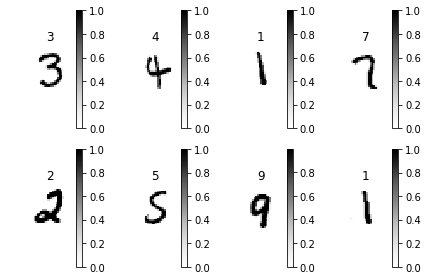

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{\sum_k q_k} = 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{q_j}{\sum_k q_k} = 0 - \frac{q_j}{Z}
\end{align}


Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$\frac{\partial log q_j}{\partial W_{ij}} = \frac{\partial (\textbf{w}_j^T\textbf{x} + b_j)}{\partial W_{ij}} = x_i$

$\frac{\partial log q_j}{\partial \textbf{w}_j} = \frac{\partial (\textbf{w}_j^T\textbf{x} + b_j)}{\partial \textbf{w}_j} = \textbf{x}^T$

so

for $j = t^{(n)}$:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \delta_j^q x_i
= x_i (1 - \frac{q_j}{\sum_k q_k})
= x_i (1 - \frac{q_j}{Z})
$ 
 
for $j \neq t^{(n)}$:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \delta_j^q x_i
= - x_i q_j  \cdot \sum_k \frac{1}{q_k}
= -x_i \frac{q_j}{\sum_k q_k}
= -x_i \frac{q_j}{Z}
$

In vector notation, using the required delta:

$
\nabla_{w_j} \mathcal{L}^{(n)} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial \textbf{w}_j}
= \mathbf{\delta}^q
\frac{\partial \log q_j}{\partial \textbf{w}_j}
= \delta^q \textbf{x}^T  
$



### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
from scipy.special import logsumexp 

def logreg_gradient(x, t, w, b):
    logq = x.dot(w) + b
    q = np.exp(logq)
    logZ = logsumexp(logq)
    Z = np.exp(logZ)
    logp = logq - logZ
    delta_q = -1/Z * q
    dL_db = delta_q
    dL_db[:,t[0]] += 1
    dL_dw = np.outer(x, dL_db)
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.36129468997e-07
Finite difference error grad_b: 5.23511748726e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b, val=False):
    lr = 10**-4
    arr = np.arange(0,len(x_train))
    np.random.shuffle(arr)
    logp_tracker = 0

    for i in arr:
      logp_train, grad_w, grad_b = logreg_gradient(x_train[i:i+1, :], t_train[i:i+1], W.reshape(784,10), b)
      logp_tracker += logp_train
      if not val:
        W = W + lr * grad_w
        b = b + lr * grad_b
    return logp_tracker/len(arr), W, b
  

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

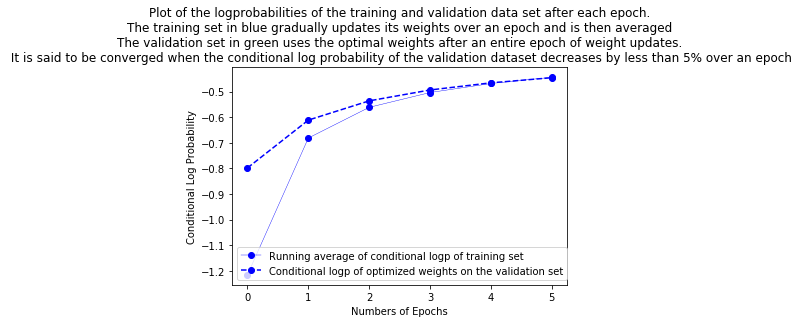

In [14]:


def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    x=[]
    x_counter=0
    y_train=[]
    y_val=[]
    converged=False
    previous_logp = None
    likelihood_growth_criterion = -0.05
    
    while not converged:
      logp_train, w, b = sgd_iter(x_train, t_train, w, b)
      logp_val, w_val, b_val = sgd_iter(x_valid, t_valid, w, b, val=True)
      if previous_logp:
        if ((logp_val - previous_logp) / previous_logp) >= likelihood_growth_criterion:
          converged = True
          
      previous_logp = logp_val
      y_train.append(logp_train)
      y_val.append(logp_val)

      x.append(x_counter)

      x_counter += 1
    plt.plot(x, y_train, 'b-o', linewidth=0.4, label='Running average of conditional logp of training set')
    plt.plot(x, y_val, 'b--o', label='Conditional logp of optimized weights on the validation set')
    plt.title('Plot of the logprobabilities of the training and validation data set after each epoch.\nThe training set in blue gradually updates its weights over an epoch and is then averaged\nThe validation set in green uses the optimal weights after an entire epoch of weight updates.\n It is said to be converged when the conditional log probability of the validation dataset decreases by less than 5% over an epoch')
    plt.xlabel("Numbers of Epochs")
    plt.ylabel("Conditional Log Probability")
    plt.legend()
    return(w, b)
    
np.random.seed(1243)
w = np.random.normal(size=(28*28,10), scale=0.001)
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)


In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


Populating the interactive namespace from numpy and matplotlib


/Users/yoni.schirris/miniconda3/envs/ml1labs/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


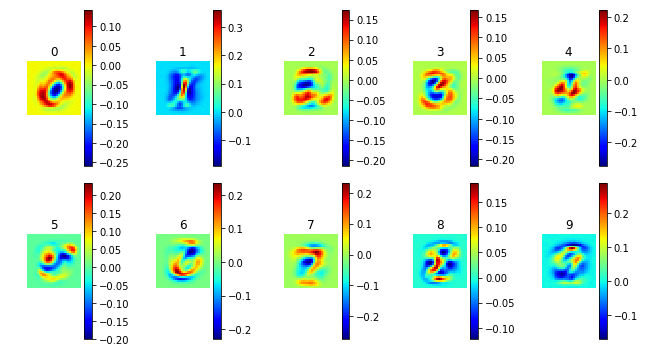

In [16]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

def plot_digits_2(data, num_cols=5, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='jet')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_digits_2(w.T, targets=[0,1,2,3,4,5,6,7,8,9])


**Describe in less than 100 words why these weights minimize the loss**

When data is encountered in a 'hot' area, the probability for that number is increased accordingly. Therefore, if there's a written number where many of its pixels fall in the area that's defined in one of the hot areas of the above 'boxes', the probability is continuously increased for each pixel that falls in one of the hot areas.

Also: There are negative weights. Pixels in these areas indicate that it is more likely that the input belongs to another true class, and therefore assigns a negative weights for that specific class. 


### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


Digits with highest probability of their true class


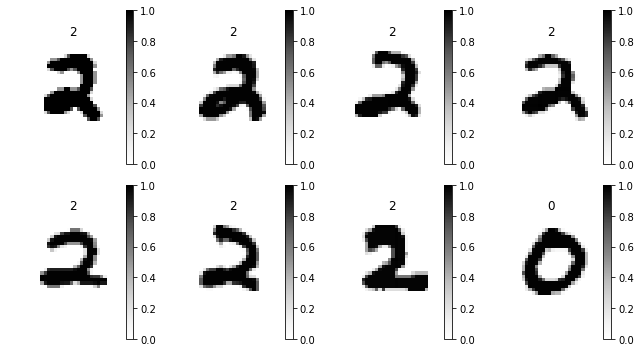

Digits with lowest probability of their true class


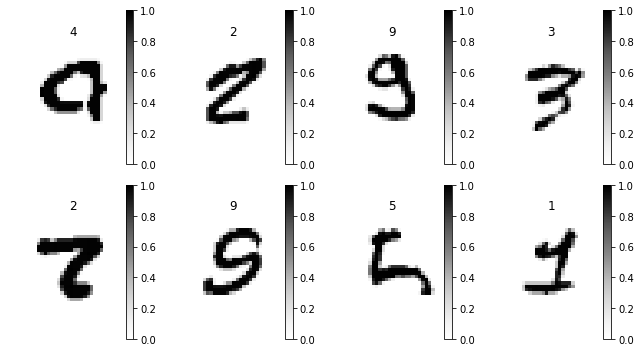

In [17]:
# get the logp for each datapoint and its actual class
listofposteriors = [
    (idx, logreg_gradient(x_valid[idx:idx+1, :], t_valid[idx:idx+1], w.reshape(784,10), b)[0])
    for idx, x in enumerate(x_valid)
]
# sort the logps
listofposteriors.sort(key=lambda tup: tup[1])

high_prob_data = []
high_prob_targets = []


# i get the 8 at the top, the highest probs
for tpl in listofposteriors[:-9:-1]:
  high_prob_data.append(x_valid[tpl[0]])
  high_prob_targets.append(t_valid[tpl[0]])


# and the 8 at the bottom, the least probable
  
low_prob_data = []
low_prob_targets = []
 
for tpl in listofposteriors[:8]:
  low_prob_data.append(x_valid[tpl[0]])
  low_prob_targets.append(t_valid[tpl[0]])
  
high_prob_data = np.array(high_prob_data)
low_prob_data = np.array(low_prob_data)

# then i plot those data points
print("Digits with highest probability of their true class")
plot_digits(np.array(high_prob_data), num_cols=4, targets=high_prob_targets)
print("Digits with lowest probability of their true class")
plot_digits(np.array(low_prob_data), num_cols=4, targets=low_prob_targets)


#print(listofposteriors[:-10: -1])




Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

These results seem to make sense -- the digits classified with high confidence admittedly look quite clear, while the ones classified with low confidence will generally look less neat to a human reader as well. A digit is hard to classify when its input badly corresponds to our learned weights (= hot areas in above heatmap) for its correct class.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

### State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

$\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case because it does not depend on anything going on in the new hidden layer (or anything from before for that matter).

$\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case, but now it depends on $h$ for its input instead of directly using $x$.

### Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

<!-- 
--------------------


$\frac{\partial log q_j}{\partial W_{ij}} = \frac{\partial (\textbf{w}_j^T\textbf{x} + b_j)}{\partial W_{ij}} = x_i$

$\frac{\partial log q_j}{\partial \textbf{w}_j} = \frac{\partial (\textbf{w}_j^T\textbf{x} + b_j)}{\partial \textbf{w}_j} = \textbf{x}^T$

so

for $j = t^{(n)}$:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \delta_j^q x_i
= x_i - x_i q_j  \cdot \sum_k \frac{1}{q_k}
$

as matrix it is..

$
\textbf{x}^T \delta^q
$

1x784 x 10x1 = 784*10 matrix, so this might be correct

where x is a vector of size 784 and delta a vector of size 10
 
 
for $j \neq t^{(n)}$:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \delta_j^q x_i
= - x_i q_j  \cdot \sum_k \frac{1}{q_k}
$

In vector notation, using the required delta:

$
\nabla_{\bW_{:j}} \mathcal{L}^{(n)} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial \bW_{:j}}
= \mathbf{\delta}^q
\frac{\partial \log q_j}{\partial \bW_{:j}}
= \textbf{x} {\delta^q}^T  
$


-------------------
 -->

$
M = 28 \cdot 28 = 784
$

$
K = 10
$

$
L = $# hidden layers (= 20 for the next assignment)$
$

$
\bX \in \mathbb{R}^{N \times M}
$

$
\bX_{n:} \in \mathbb{R}^{1 \times M}
$

$
\bV \in \mathbb{R}^{M \times L}
$

$
\bV_{m:} \in \mathbb{R}^{1 \times L}
$

$
\ba \in \mathbb{R}^{L \times 1}
$

$
\bh \in \mathbb{R}^{L \times 1}
$

$
\bW \in \mathbb{R}^{L \times K}
$

$
\bW_{:k} \in \mathbb{R}^{L \times 1}
$

$
\bW_{l:} \in \mathbb{R}^{1 \times K}
$

$
\bb \in \mathbb{R}^{K \times 1}
$

$
\log q_j = \bW_{:j}^T \bh + b_j \in \mathbb{R}
$

$
\log \bq = \bW^T \bh + \bb \in \mathbb{R}^{K \times 1}
$

$
h_j = \sigma(\bV_{j:}^T \bX_{n:}^T + a_j) \in \mathbb{R}
$

$
\bh = \sigma(\bV^T \bX_{n:}^T + \ba) \in \mathbb{R}^{L \times 1}
$

$
\delta^q_j = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} = t^{(n)}_j - \frac{q_j}{Z} \in \mathbb{R}
$

$
\delta^{\bq} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log \bq} = \mathbb{I}(j = t^{(n)}) - \frac{1}{Z} \bq \in \mathbb{R}^{K \times 1}
$

$
\delta^h_j = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_j} = \delta^q \cdot \dfrac{\partial \log \bq}{\partial h_j} = \delta^q \cdot \bW_{j:}^T \in \mathbb{R}
$

$
\delta^{\bh} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \bh} = \delta^{\bq} \cdot \dfrac{\partial \log \bq}{\partial \bh} = \bW \cdot \delta^q \in \mathbb{R}^{L \times 1}
$

<!-- 
$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial \bW} = \delta^q_j \cdot \dfrac{\partial \log q}{\partial \bW} = \delta^q_j \cdot h_j
$
 -->
 
$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
= \delta_j^q h_i
% = - h_i q_j  \cdot \sum_k \frac{1}{q_k}
 \in \mathbb{R}
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial \bW} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log \bq}
\frac{\partial \log \bq}{\partial W}
= \mathbf{\delta}^q
\frac{\partial \log q}{\partial W}
= \bh \cdot \mathbf{\delta}^{q^T}
% = - \bh^T \bq \cdot \sum_k \frac{1}{q_k}
 \in \mathbb{R}^{L \times K}
$

$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial \bb} = \mathbf{\delta}^q \cdot \dfrac{\partial \log \bq}{\partial \bb} = \delta^\bq \cdot 1 = \delta^\bq \in \mathbb{R}^{K \times 1}
$

$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial \bV} = \delta^\bh \cdot \dfrac{\partial \bh}{\partial \bv} = ((\delta^{\bh} \times (\bh \times (\mathbf{1} - \bh))) \cdot \bX_{n:})^T \in \mathbb{R}^{M \times L}
$

$
\dfrac{\partial \mathcal{L}^{(n)}}{\partial \ba} = \delta^\bh \cdot \dfrac{\partial \bh}{\partial \ba} = \delta^{\bh} \times (\bh \times (\mathbf{1} - \bh)) \in \mathbb{R}^{L \times 1}
$




## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

For the maximum likelihood solution, we set the gradient of the log likelihood to zero.
In the case of maximum a posteriori, we would first calculate the posterior using bayes rule, i.e. by multiplying the likelihood with the prior and dividing through the evidence, taking the log, and then to go through a similar derivation as done above to set the derivative of the posterior w.r.t. all the parameters to 0. The evidence term will be marginalized out and the entire derivation is as straightforward as the steps above.

Given that you have already derived the above steps, you could simply add the gradient of the Gaussian w.r.t. the parameter to the gradient as derived above, which will give you the gradient of the MAP! This way, you can use SGD to find the MAP solution.


## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
# Write all helper functions here
from scipy.special import logsumexp, expit

M = 28*28
K = 10
L = 20

# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def mlp_logreg_gradient(x, t, v, w, a, b):
    a = a.reshape((L, 1))
    b = b.reshape((K, 1))
    v = v.reshape((M, L))
    w = w.reshape((L, K))
    h = expit(np.add(v.T.dot(x.T), a))
    logq = w.T.dot(h) + b
    q = np.exp(logq)
    logZ = logsumexp(logq)
    Z = np.exp(logZ)
    logp = logq - logZ
    dL_dq = -1/Z * q
    delta_q = dL_dq
    delta_q[t[0],:] += 1
    dL_dh = w.dot(delta_q)
    delta_h = dL_dh
    dL_db = delta_q
    dL_dW = h.dot(delta_q.T)
    dL_da = delta_h * h * (1 - h)
    dL_dV = dL_da.dot(x).T
    return logp[t].squeeze(), dL_dV, dL_dW, dL_da.squeeze(), dL_db.squeeze()


def mlp_iter(x_train, t_train, v, w, a, b, lr=10**-4, val=False):
    arr = np.arange(0,len(x_train))
    np.random.shuffle(arr)
    logp_tracker = 0

    for i in arr:
      logp_train, grad_v, grad_w, grad_a, grad_b = mlp_logreg_gradient(x_train[i:i+1, :], t_train[i:i+1], v, w, a, b)
      logp_tracker += logp_train

      if not val:
        v = v + lr * grad_v
        w = w + lr * grad_w
        a = a + lr * grad_a
        b = b + lr * grad_b
    return (logp_tracker/len(arr)), v, w, a, b


def test_mlp(x_train, t_train, x_valid, t_valid, v, w, a, b, lr=10**-4):
    epochs = 10
    y_train = []
    y_val = []
    v_epoch = []

    # train the model for 10 epochs
    for epoch in range(epochs):

      logp_train, v, w, a, b = mlp_iter(x_train, t_train, v, w, a, b, lr)
      logp_val, v_val, w_val, a_val, b_val = mlp_iter(x_valid, t_valid, v, w, a, b, lr, val=True)
      y_train.append(logp_train)
      y_val.append(logp_val)
      v_epoch.append(v)

    xs = range(epochs)
    return (v, w, a, b, xs, y_train, y_val, v_epoch)


In [19]:
# Hidden tests for efficiency

In [20]:
# Write training code here:

np.random.seed(1243)
# single hidden layer of 20 neurons
lrs = [1e-2, 1e-3, 1e-4]
results = []
# test your implementation for learning rates of 1e-2, 1e-3 and 1e-4
for idx, lr in enumerate(lrs):
  v = np.random.normal(size=(M,L), scale=0.1)
  a = np.random.normal(size=L, scale=0.1)
  w = np.random.normal(size=(L,K), scale=0.1)
  b = np.random.normal(size=K, scale=0.1)
  v, w, a, b, xs, y_train, y_val, v_epoch = test_mlp(x_train, t_train, x_valid, t_valid, v, w, a, b, lr)
  results.append((v, w, a, b, xs, y_train, y_val, v_epoch))


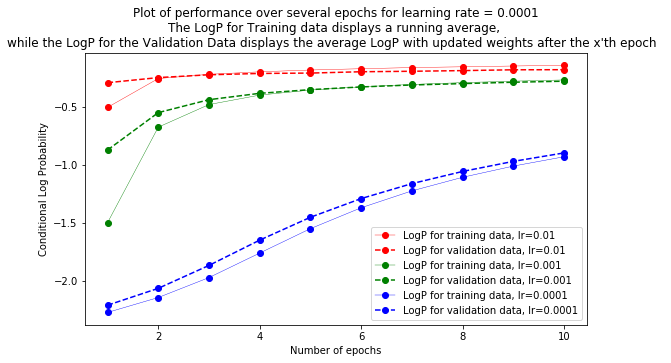

In [21]:
# plot the train and validation logp for all three learning rates in one figure

colors = ['r', 'g', 'b']
for idx, res in enumerate(results):
    v, w, a, b, xs, y_train, y_val, v_epoch = res
    xs = np.array(xs) + 1
    color = colors[idx]
    
    plt.plot(xs, y_train, f'{color}-o', linewidth=0.4, label="LogP for training data, lr={}".format(lrs[idx]))
    plt.plot(xs, y_val, f'{color}--o', label="LogP for validation data, lr={}".format(lrs[idx]))
    plt.xlabel("Number of epochs")
    plt.ylabel("Conditional Log Probability")
    plt.title("Plot of performance over several epochs for learning rate = {}\nThe LogP for Training data displays a running average, \nwhile the LogP for the Validation Data displays the average LogP with updated weights after the x'th epoch  ".format(lr))
    plt.legend()
    
plt.show()
    
  
  



### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

Low lr: The model requires more rounds to converge, but does not seem to overfit the model (logp(validation) > logp(training))

Medium lr: It takes a few epochs to level out, but it quickly reaches a high level of log probability.

High lr: It converges very quickly, but is overfitting the model on the training data (logp(training) > logp(validation)). Its performance on the validation data is still better than all other learning rates: you gain speed and don't lose model stability.



### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

Populating the interactive namespace from numpy and matplotlib
epoch 0


/Users/yoni.schirris/miniconda3/envs/ml1labs/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


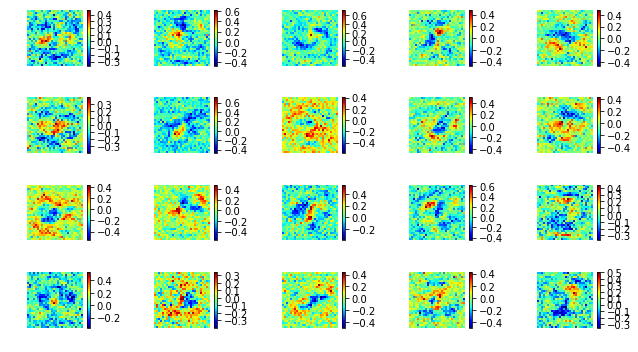

epoch 4


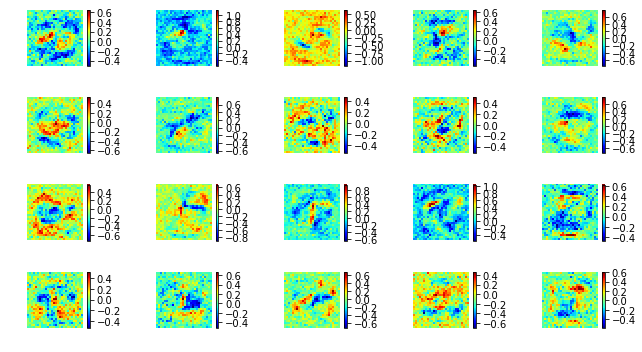

epoch 9


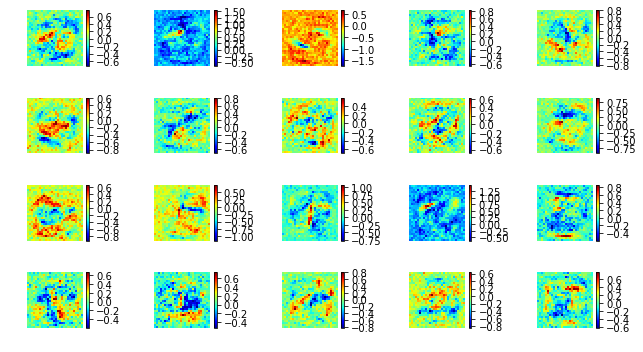

In [22]:
# Plot the weights of the first layer.
# Plot the weights of the first layer for the best model 
# For the best model plot the weights of the first layer for in epoch 0, 4 and 9.

%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

best_idx = 0  # learning rate 0.01 had the best score, though slight overfit as well
for epoch in [0, 4, 9]:
  print('epoch', epoch)
  v, w, a, b, xs, y_train, y_val, v_epoch = results[best_idx]
  plot_digits_2(v_epoch[epoch].T)


As the MLP no longer needs to 'directly' capture its entire model in its single weight matrix, it is now able to create a division of labor among its two distinct layers. Above one can see that there seem to be some 'structures' in the weights, numbers can't be recognized as before. This is because the 784 input data points per image are first mapped to 20 dimensions which does not involve a clear human intuitive meaning anymore. The weights that perform this 'unintuitive' mapping are the weights that are plotted above. This additional layer of non-linear abstraction is what allows it to create a more powerful final model, explaining its better performance vs Logistic Regression (which is in essence a 1-layer neural network with a hidden layer with a linear identity activation function and softmax activation function in the last layer).




### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

${\frac{d}{dx}}\tanh(x) = 1-\tanh^{2}(x)$

$
{\frac{d}{dx}}\operatorname{ReLU}(x) =
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases}
$

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

The activation function should ideally:
- be non-linear: required for the network to be able to model non-linear functions
<!-- all have this -->
<!-- - be monotonically increasing: a higher input should not result in a lower output -->
<!-- all have this -->
<!-- - have a derivative that is monotonically increasing -->
<!-- favors ReLU -->
- have an easily calculated derivative: helps for performance
<!-- favors ReLU but it's better suited for regression -->
<!-- - be continuously differentiable:  -->
<!-- not ReLU -->
<!-- - approximate the identity function near the origin: helps learn efficiently when its weights are initialized with small random values. -->
<!-- tanh > ReLU > sigmoid -->
<!-- - be scale equivariant -->
<!-- favors ReLU -->
<!-- - be symmetric about the origin: otherwise it will be more prone to saturation of the later layers, making training more difficult. -->
<!-- favors tanh -->


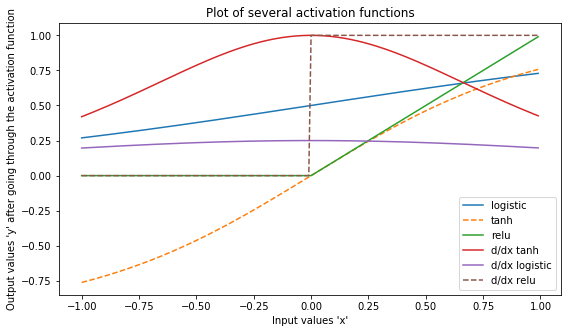

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-1, 1, 0.01);

plt.plot(x, expit(x), label='logistic')
plt.plot(x, np.tanh(x), '--', label='tanh')
plt.plot(x, np.maximum(0, x), linewidth="1.5", label='relu')
plt.plot(x, 1 - np.tanh(x) ** 2, label='d/dx tanh')
plt.plot(x, expit(x) * (1 - expit(x)), label='d/dx logistic')
plt.plot(x, (x > 0) * 1, '--', label='d/dx relu')
plt.title("Plot of several activation functions")
plt.xlabel("Input values 'x'")
plt.ylabel("Output values 'y' after going through the activation function")

plt.legend()


Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

Each of these functions is non-linear, but ReLU seems to have the derivative that is easiest to calculate (given it's defined for $x=0$). This seems to make ReLU a good choice for our hidden layer, although the one-hot output layer of our classification model will still need an activation function yielding a total of $1$ over all the outputs, like softmax.

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 7.26 minutes.
